# Гибридная система идентификации автомобилей

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pysim.experiments.utility.graphs_style import (
    get_color, setup_matplotlib, savefig
)

from pysim.models.hybrid.cli import check_vars_for_multiprocessing, run_multiple_simulation
from pysim.models.hybrid.objects import Params
from pysim.models.hybrid.processing import result_processing

## Зависимость вероятности идентификации автомобиля от **вероятности идентификации RFID системой**

### Подготовка входных данных в модель

In [2]:
params_scheme = Params()
params_dict = params_scheme.model_dump()
params_dict["photo_error"] = params_scheme.symbol_error
rfid_probs = np.linspace(0, 1, 25).tolist()
variadic = "rfid_error"
params_dict["rfid_error"] = rfid_probs

### Запуск симуляции

In [3]:
statistica = run_multiple_simulation(variadic, **params_dict)
results = result_processing(params_dict, statistica, variadic, print_res=False)

In [4]:
res_probs = []
for res in results:
    res_probs.append(res.total_prob)

## Построение графиков

In [5]:
setup_matplotlib()
DIRECTORY = "Hybrid"

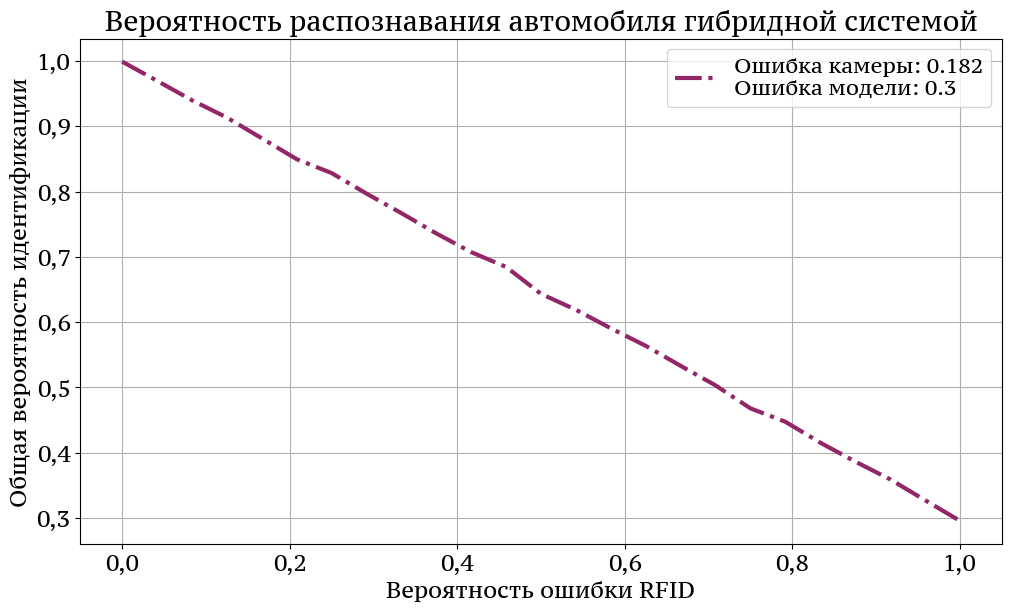

In [10]:
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")

ax.plot(
    rfid_probs, res_probs,
    linewidth=3, linestyle="dashdot",
    label=f"Ошибка камеры: {params_dict['photo_error']:.3f}\nОшибка модели: {params_dict['car_error']}",
    color=get_color(0.4)
)
ax.set_xlabel("Вероятность ошибки RFID")
ax.set_ylabel("Общая вероятность идентификации")
plt.tick_params(axis="both", which="major")
plt.title("Вероятность распознавания автомобиля гибридной системой")
plt.legend(prop={"size":15})
plt.grid()

savefig(name=f"", directory=DIRECTORY)

## Зависимость вероятности идентификации автомобиля от **вероятности фотофиксации**
Семейство кривых для разных вероятностей RFID

## Зависимость вероятности идентификации автомобиля от **вероятности определения модели**
Семейство кривых для разных вероятностей RFID и фотофиксации

## Зависимость доли коллизий от **вероятности определения модели**
Семейство кривых для разных вероятностей RFID и фотофиксации

## Количество неразрешённых коллизий при больших вероятностях ошибки идентификации

## Количество неправильно разрешённых коллизий при больших вероятностях ошибки идентификации